# 1. 导入python库

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score


# 2. 参数设置

In [2]:
daily_back=20
wenben_back=10

wenben_sort=2

batch_size=8
epochs=100

LSTM_num=100
dense_num=20


mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=1915 #根据查看数据表，得到数值
train_num=1149
test_num=total_day-train_num

# 3. 读取原始数据

In [3]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 4. 标准化

## 4.1 历史数据标准化函数norm

In [4]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

## 4.2 文本数据标准化函数wenben_norm

In [5]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)

    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()

    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    
    df=x
    
    return df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [6]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

## 5.2 进行数据切分

In [7]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1149, 8)
日频测试切分： (766, 8)
十五分钟频训练切分： (18384, 6)
十五分钟频测试切分： (12432, 6)
训练目标切分： (1149, 2)
测试目标切分： (777, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [8]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.wenben_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [9]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back)

# 6.3 调用类中的方法,处理原始数据

In [10]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)

wenben_train=DM.wenben_train_data(wenben_norm_train_df)

wenben_test=DM.wenben_test_data(wenben_norm_test_df)


(1129, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148],
      dtype='int64', length=1149)
日频训练array： (1129, 20, 5)
766 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

# 7. 神经网络模型训练

## 7.1 模型建立 

In [11]:
def my_model():

    # 假设的参数
    LSTM_num = 32
    dense_num = 64

    model = Sequential()
    # 使用 Input 层指定输入形状
    model.add(Input(shape=(20, 5)))
    model.add(Conv1D(16, 1, strides=1))
    model.add(LSTM(LSTM_num))
    model.add(Dense(dense_num, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['acc'])
    return model
   


## 7.2 模型滞后时长赋值

In [12]:
model=my_model()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 16)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,545 (33.38 KB)

 Trainable params: 8,545 (33.38 KB)

 Non-trainable params: 0 (0.00 B)

## 7.3 添加输出模型参数的代码块

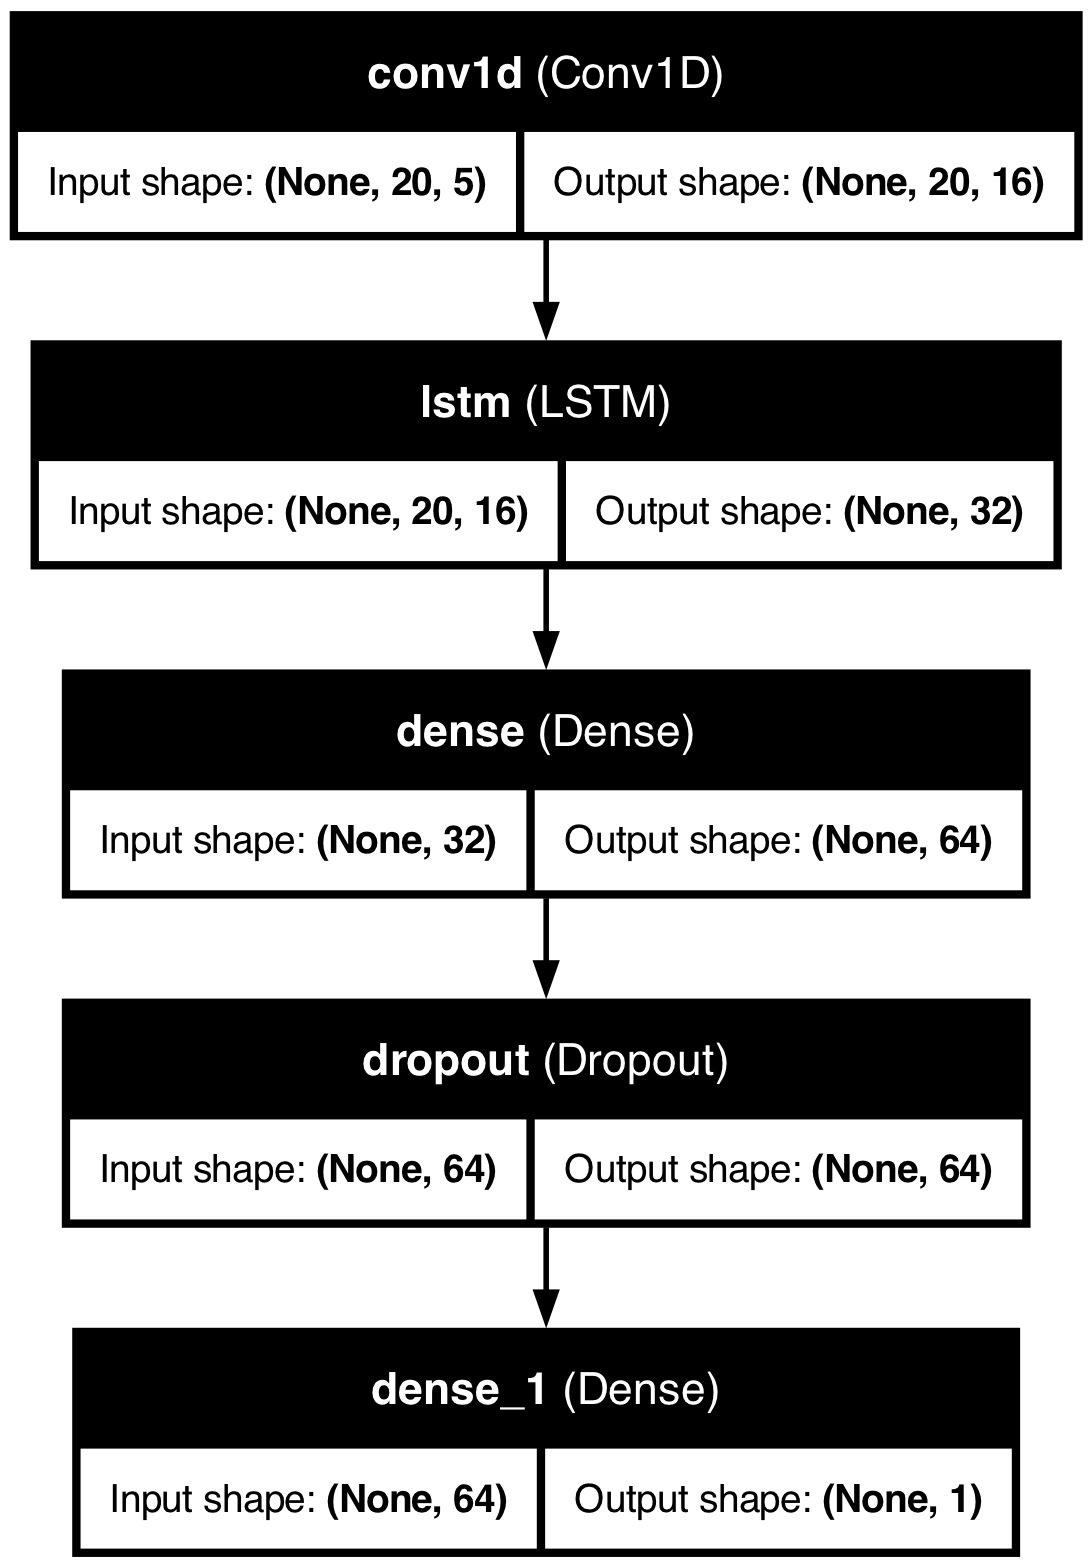

In [13]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 7.4 model.fit(输入训练数据x，标志y)

In [14]:
history = model.fit(x=daily_train,y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5230 - loss: 0.6957 - val_acc: 0.5159 - val_loss: 0.7414
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5283 - loss: 0.6881 - val_acc: 0.5159 - val_loss: 0.7370
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5729 - loss: 0.6828 - val_acc: 0.5159 - val_loss: 0.7175
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5489 - loss: 0.6871 - val_acc: 0.5159 - val_loss: 0.7605
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5619 - loss: 0.6829 - val_acc: 0.5159 - val_loss: 0.7366
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5719 - loss: 0.6786 - val_acc: 0.5159 - val_loss: 0.7209
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5625 - loss: 0.6784 - val_acc: 0.5159 - val_loss: 0.7297
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5498 - loss: 0.6791 - val_acc: 0.5159 - val_loss: 0.7415
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [15]:
loss,accuracy = model.evaluate(daily_test,y=target_test)
print(loss,accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4843 - loss: 1.5227 
1.2557051181793213 0.479892760515213


# 8. 回测

# 构建y的函数

In [16]:
def gen_y_pred():
    y_predict=model.predict(daily_test,batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [17]:
y_pred=gen_y_pred()
print(y_pred)

746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,

#  构建使用测试集作为回测数据的类

In [18]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back,wenben_back):
        self.train_num=train_num
        self.daily_back=daily_back
        self.wenben_back = wenben_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.wenben_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [19]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20,wenben_back=daily_back)

In [20]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [21]:
back_df=split_back_trader()['daily_test_df']

In [22]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1149,2021-10-14,3555.11,3569.69,3547.18,3558.28,294969196,145354,-0.641130
1150,2021-10-15,3551.99,3578.77,3542.69,3572.37,320292984,135808,-0.727933
1151,2021-10-18,3571.05,3571.05,3539.48,3568.14,340950616,137635,-0.573483
1152,2021-10-19,3562.30,3596.79,3560.62,3593.15,334197652,130700,-0.484055
1153,2021-10-20,3583.24,3596.05,3574.30,3587.00,344245008,130572,-0.602355
...,...,...,...,...,...,...,...,...
1910,2024-12-02,3328.48,3369.30,3323.01,3363.98,668477762,428407,-0.647137
1911,2024-12-03,3366.29,3386.62,3348.37,3378.81,663030139,438283,-0.861024
1912,2024-12-04,3376.57,3388.02,3352.94,3364.65,621028862,425902,-0.984183
1913,2024-12-05,3353.06,3377.06,3353.06,3368.86,543885746,397751,-0.812990


In [23]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158,
       ...
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914],
      dtype='int64', length=766)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [24]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+20+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+20+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

745
         open    close  rate_of_return  day_rate_of_return
1170  3534.15  3539.10        0.001786            0.001401
1171  3542.90  3533.30       -0.001639           -0.002710
1172  3530.46  3521.79       -0.003258           -0.002456
1173  3518.56  3537.37        0.004424            0.005346
1174  3531.49  3520.71       -0.004710           -0.003053
...       ...      ...             ...                 ...
1910  3328.48  3363.98        0.011279            0.010666
1911  3366.29  3378.81        0.004408            0.003719
1912  3376.57  3364.65       -0.004191           -0.003530
1913  3353.06  3368.86        0.001251            0.004712
1914  3370.94  3404.08        0.010455            0.009831

[745 rows x 4 columns]
         open    close  rate_of_return  day_rate_of_return  last_close  \
1169  3486.45  3532.79             NaN            0.013291         NaN   
1170  3534.15  3539.10        0.001786            0.001401     3532.79   
1171  3542.90  3533.30       -0.001639    

# 回测交易逻辑

In [25]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+20 + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+20 + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+20 + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [26]:
result=backtrader(y_pred,backtrader_df)
print(result[1])
print(result[2])
print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


[0.013291456926099565, 0.0017861237152505538, -0.0016388347319938878, -0.0032575779016783546, 0.004423886716697911, -0.004709713713860864, 0.011264773298567565, 0.006097680859011856, -0.00043829283544749575, -0.002563039358377428, -0.005605187239480114, -0.009938020644820966, 0.004211247399554807, -0.000852696057189295, 0.009398853893850756, -0.005022966488608227, 0.0016103373628915119, 0.011816115869143662, 0.009751015100740279, -0.0018213795657003873, 0.00401761970351977, -0.005310941354167764, -0.0037962272601890223, 0.007508985286336589, -0.011608100091972218, -0.010670748494092108, 0.008773931433659898, -0.000692388962602819, 0.0057196172935611855, -0.006941432861056085, -0.0005748953165379822, 0.003910430672821041, -0.009120935729220347, 0.00616902974701139, 0.005689118283372929, -0.0020468270060278737, -0.010227594959709041, -0.002531166728786838, -0.0018237183777272126, 0.003905529760807269, -0.007257507958770226, 0.008406588478012234, -0.01172225727811227, -0.00956329494889263

In [27]:
returns=result[3]
returns = [ret - 1 for ret in returns]
returns

[0.013291456926099565,
 0.015101320827776155,
 0.013437737526710736,
 0.010136385148216798,
 0.014605114084527138,
 0.009826614464569783,
 0.021202082347373086,
 0.02742904673808577,
 0.026978731947969736,
 0.02434654503777045,
 0.01860489085471917,
 0.008481974420489369,
 0.012728941512765601,
 0.011865391537336123,
 0.021375766512639727,
 0.016245430265170224,
 0.017881928251394008,
 0.029909339056719775,
 0.0399520005742553,
 0.038057853251100004,
 0.042228374935715074,
 0.03669316115878196,
 0.0327576383199395,
 0.04051260023043568,
 0.028434225820002546,
 0.017460062853561054,
 0.026387187681525592,
 0.025676528521417996,
 0.03154300573154889,
 0.024382619213971335,
 0.023793706443842266,
 0.027797180756161444,
 0.0184227087278106,
 0.024705388712984444,
 0.0305350588749822,
 0.028425731885818317,
 0.017907410053947803,
 0.0153309166846336,
 0.013479239032401225,
 0.017437412362402593,
 0.010053352244631775,
 0.018544455117789127,
 0.006604814965703643,
 -0.0030216437767888182,
 0

In [28]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -261.91%


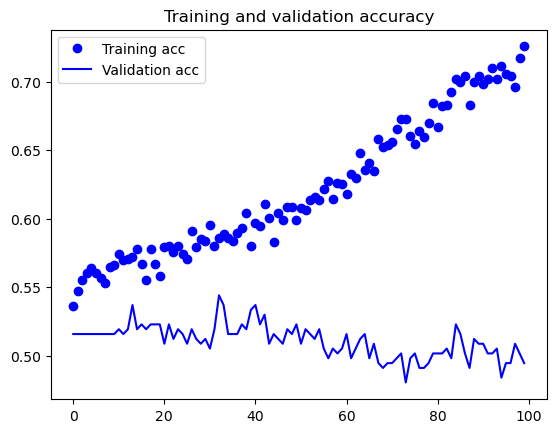

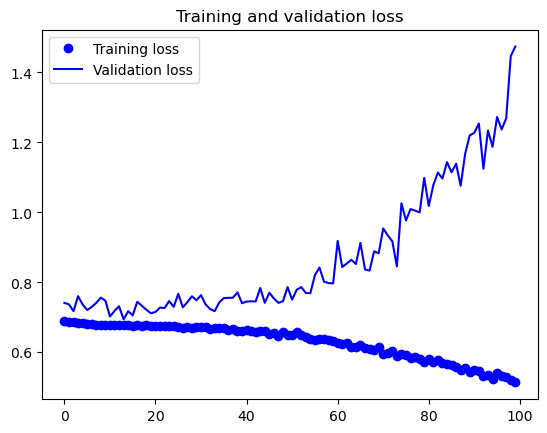

In [29]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [30]:
confusion_matrix = confusion_matrix(target_test, y_pred,labels=[1,0])
precision_score=precision_score(target_test, y_pred)
recall_score=recall_score(target_test, y_pred)
f1_score=f1_score(target_test, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[206 161]
 [227 152]]
查准率： 0.47575057736720555
查全率： 0.5613079019073569
f1-score: 0.515


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


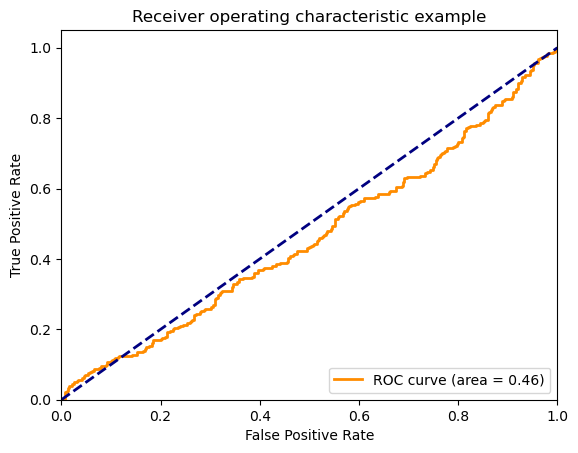

In [31]:
y_predict=model.predict(daily_test).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [32]:
# df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
# df10=pd.DataFrame({'每日收益率':result[1]})
# path9='/Users/ccmac/Desktop'
# df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
# df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [33]:
# import numpy as np
# t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
# y = np.cumprod(t, axis=1)
# print(t)
# print(y)
